In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import datetime

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [43]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
police_shooting = pd.read_csv('US Police shootings in from 2015-22.csv')
us_population_by_state = pd.read_csv('nst-est2021-popchg2010-2022.csv')

In [4]:
len(police_shooting.columns), len(police_shooting)

(17, 7729)

In [5]:
def plot_Null_values(df: pd.DataFrame):
    ig,(ax) = plt.subplots(figsize=(25,10), ncols=1)
    plt.xticks(rotation=45)

    fruits = df.columns
    counts = df.isna().sum().to_numpy()

    ax.bar(fruits, counts)

    ax.set_ylabel('NULL count')
    ax.set_title('Fruit supply by kind and color')
    ax.legend(title='Fruit color')

    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


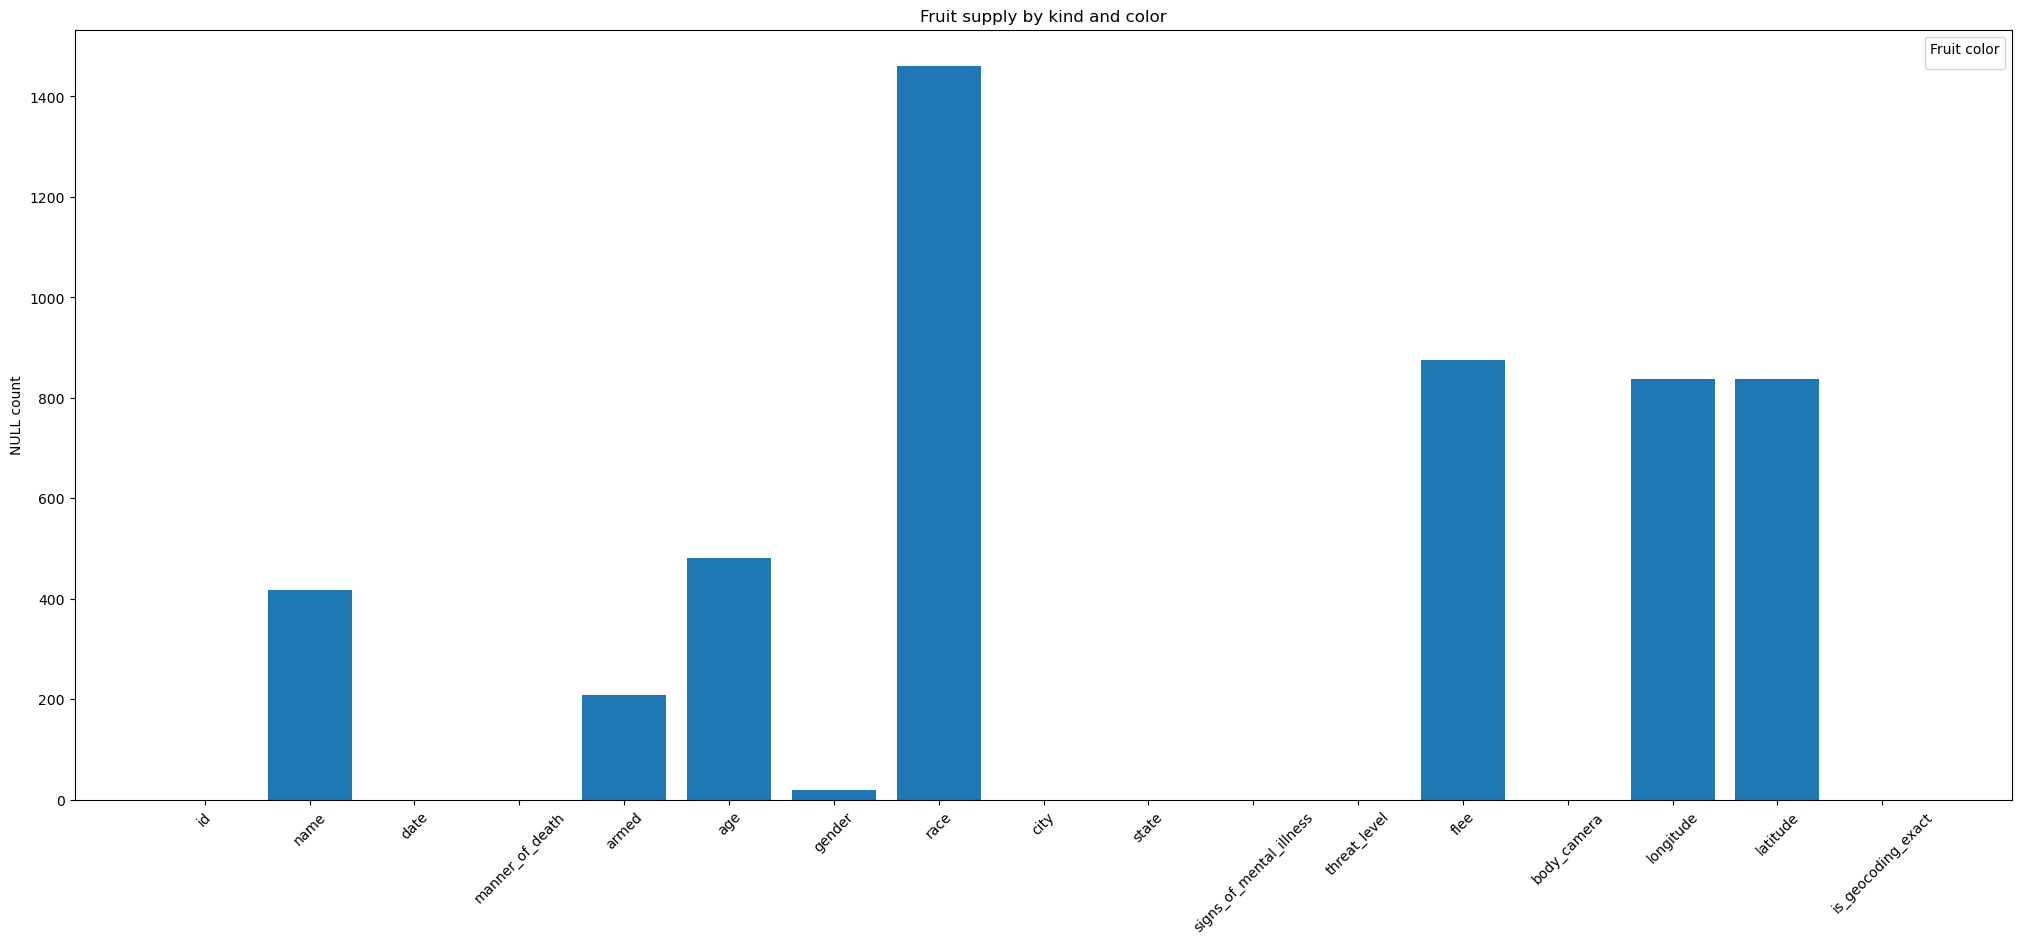

In [6]:
plot_Null_values(police_shooting)

In [7]:
police_shooting_2 = police_shooting.drop(columns=['id', 'name', 'manner_of_death', 'gender', 'is_geocoding_exact'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


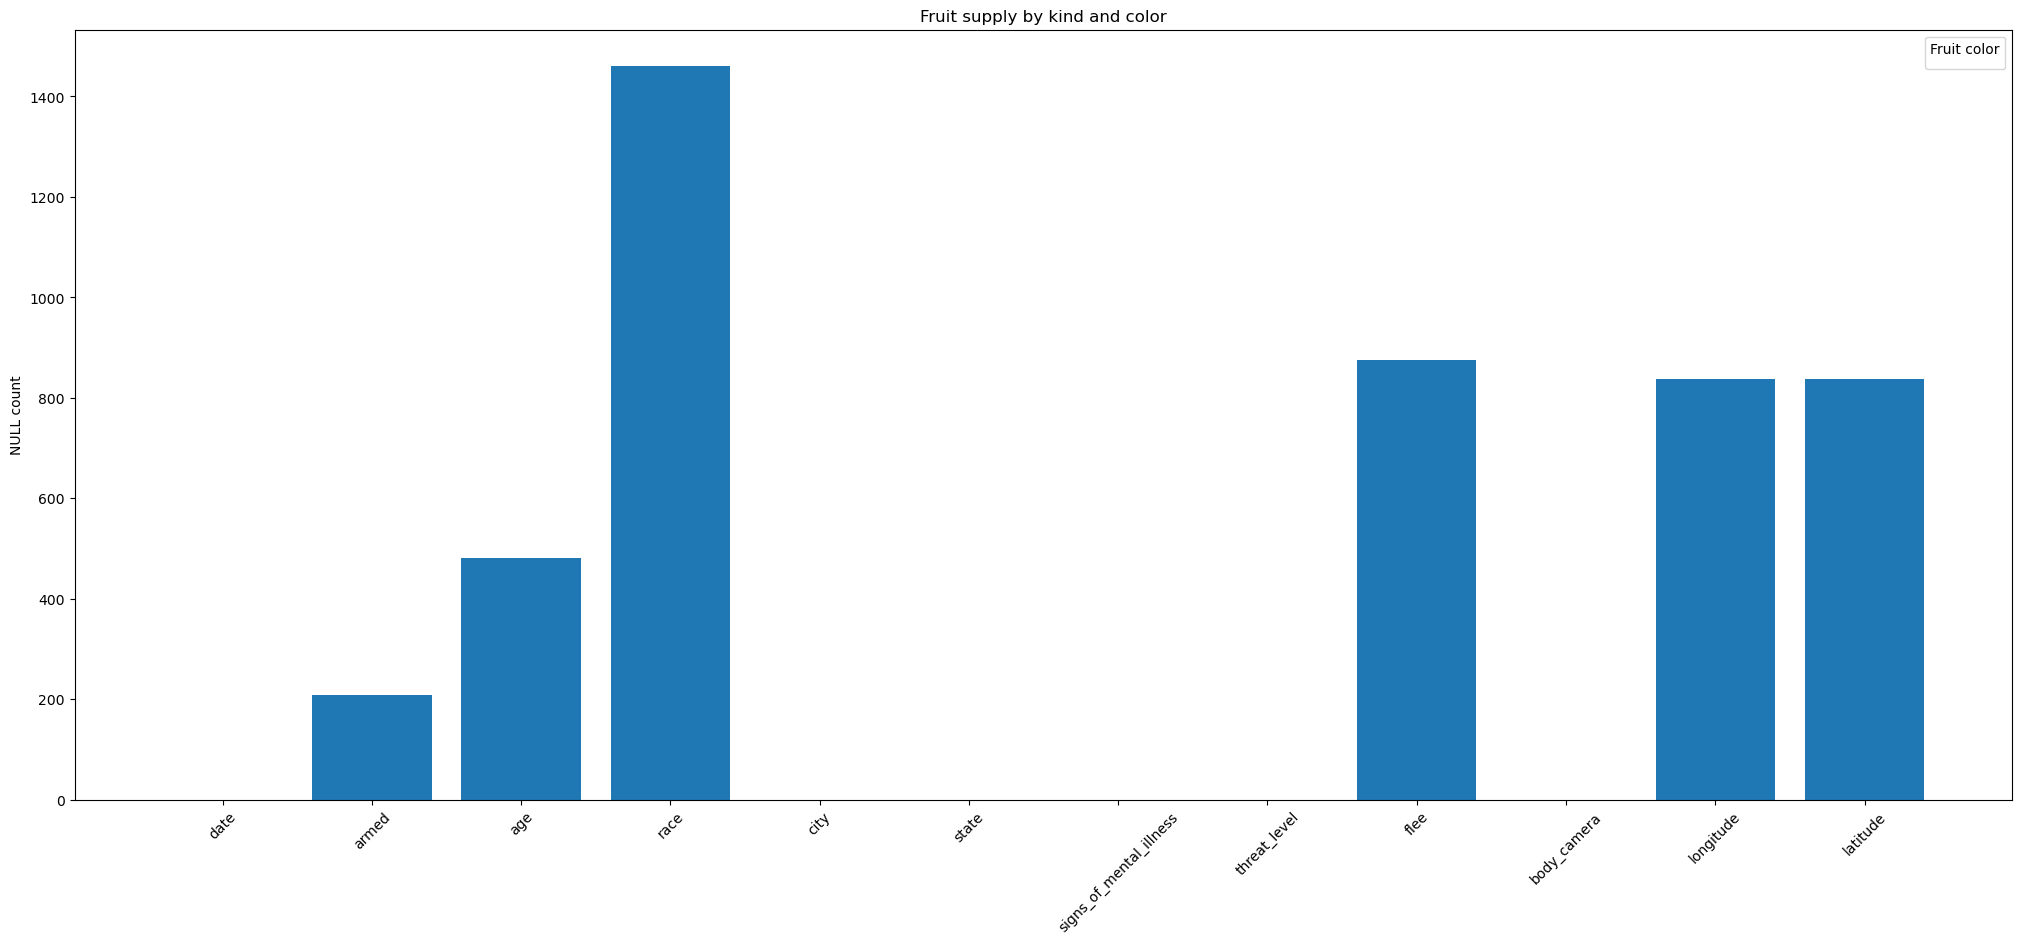

In [8]:
plot_Null_values(police_shooting_2)

<AxesSubplot:>

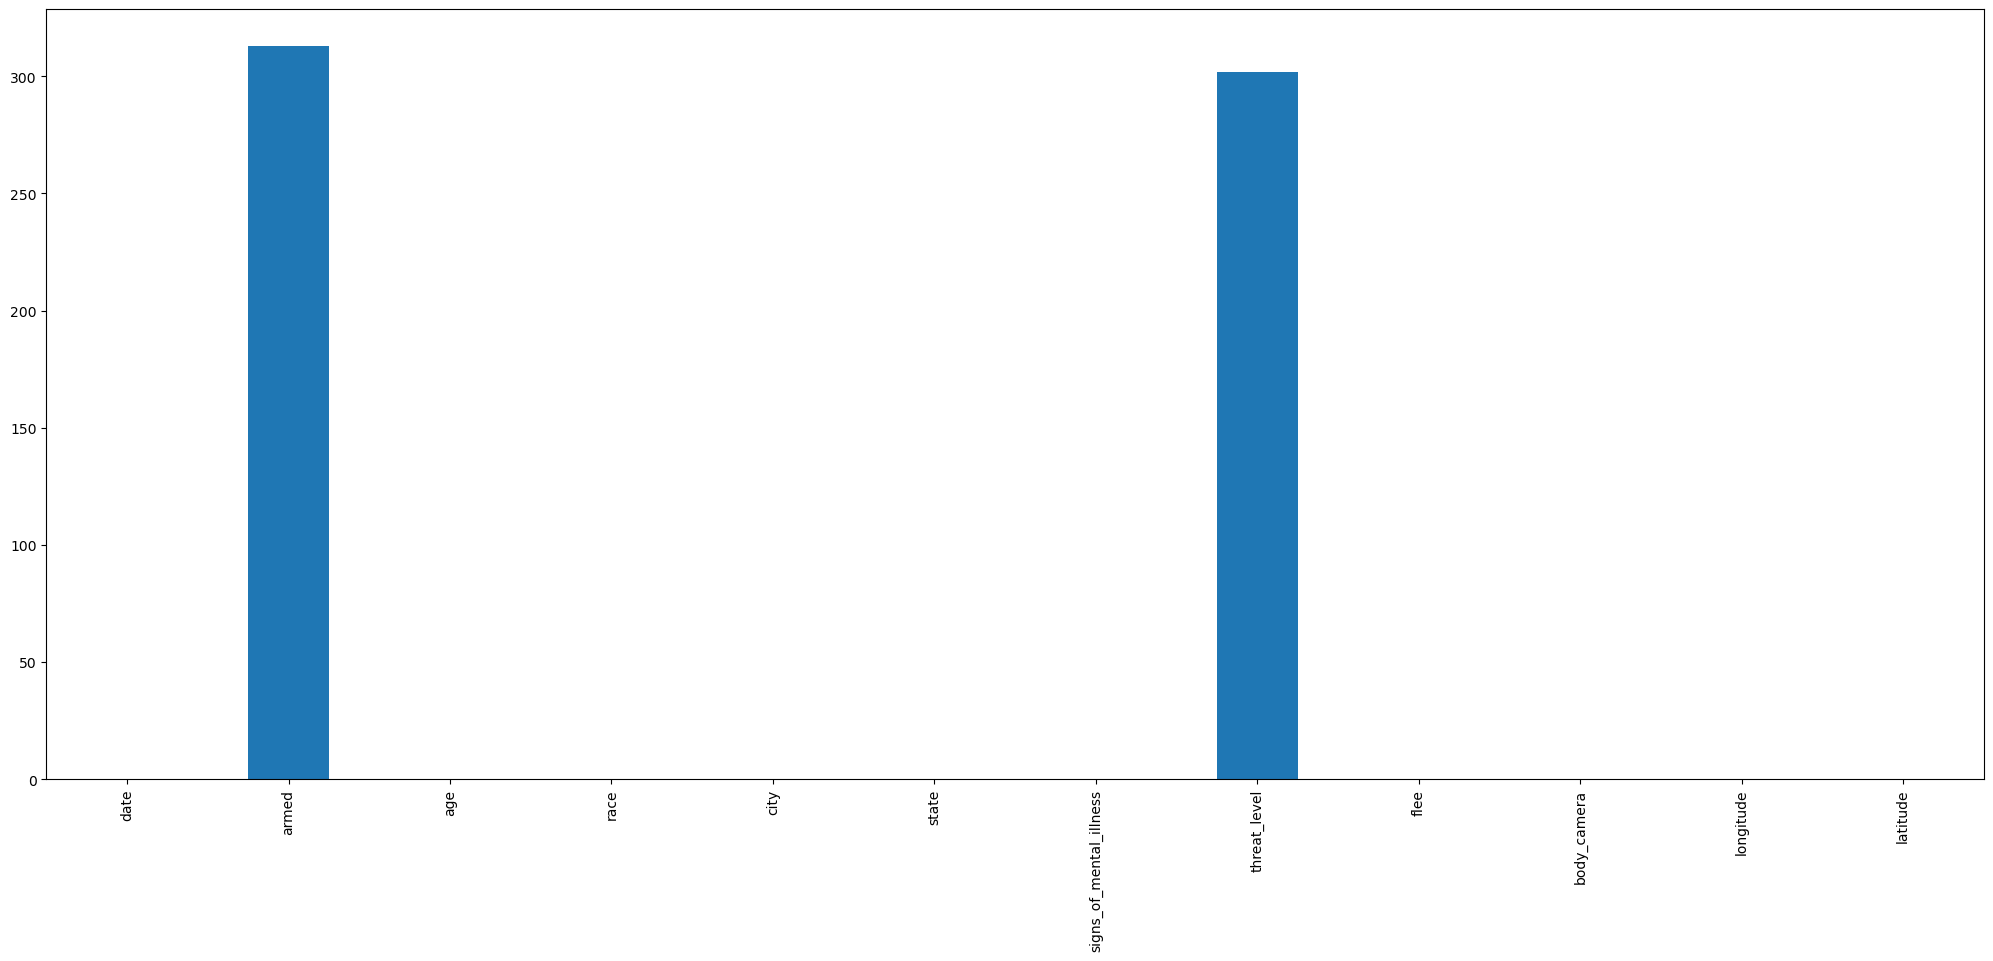

In [9]:
police_shooting_2.eq('undetermined').sum(axis=0).plot(kind='bar', figsize=(25, 10))

In [10]:
police_shooting_2['armed'].fillna('NG', inplace=True)
police_shooting_2['race'].fillna('NG', inplace=True)
police_shooting_2['flee'].fillna('NG', inplace=True)
police_shooting_2['threat_level'].fillna('NG', inplace=True)
police_shooting_2['age'].fillna(police_shooting_2['age'].median(), inplace=True)
police_shooting_2['latitude'].fillna(police_shooting_2['longitude'].mode().iloc[0], inplace=True)
police_shooting_2['longitude'].fillna(police_shooting_2['longitude'].mode().iloc[0], inplace=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


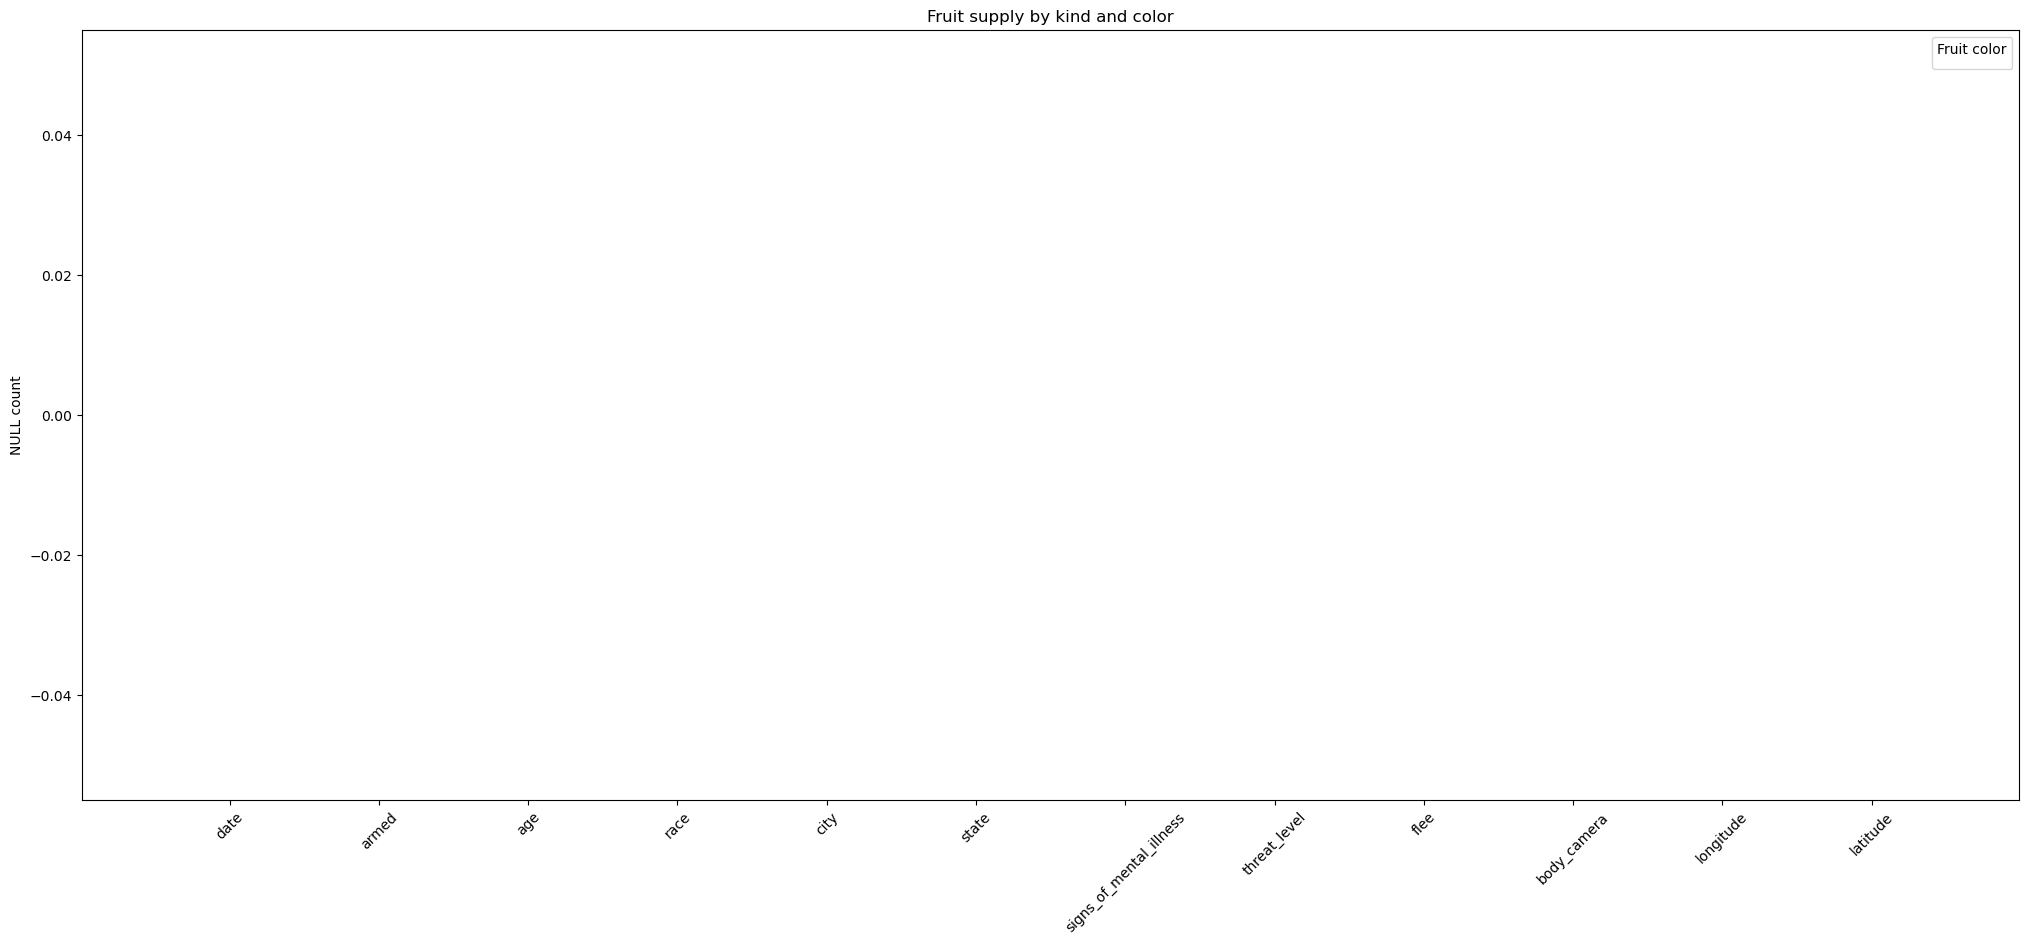

In [11]:
plot_Null_values(police_shooting_2)

In [12]:
police_shooting_2['date'] = pd.to_datetime(police_shooting_2['date'])
police_shooting_2['armed'] = police_shooting_2['armed'].astype("string")
police_shooting_2['race'] = police_shooting_2['race'].astype("string")
police_shooting_2['city'] = police_shooting_2['city'].astype("string")
police_shooting_2['state'] = police_shooting_2['state'].astype("string")
police_shooting_2['threat_level'] = police_shooting_2['threat_level'].astype("string")
police_shooting_2['flee'] = police_shooting_2['flee'].astype("string")

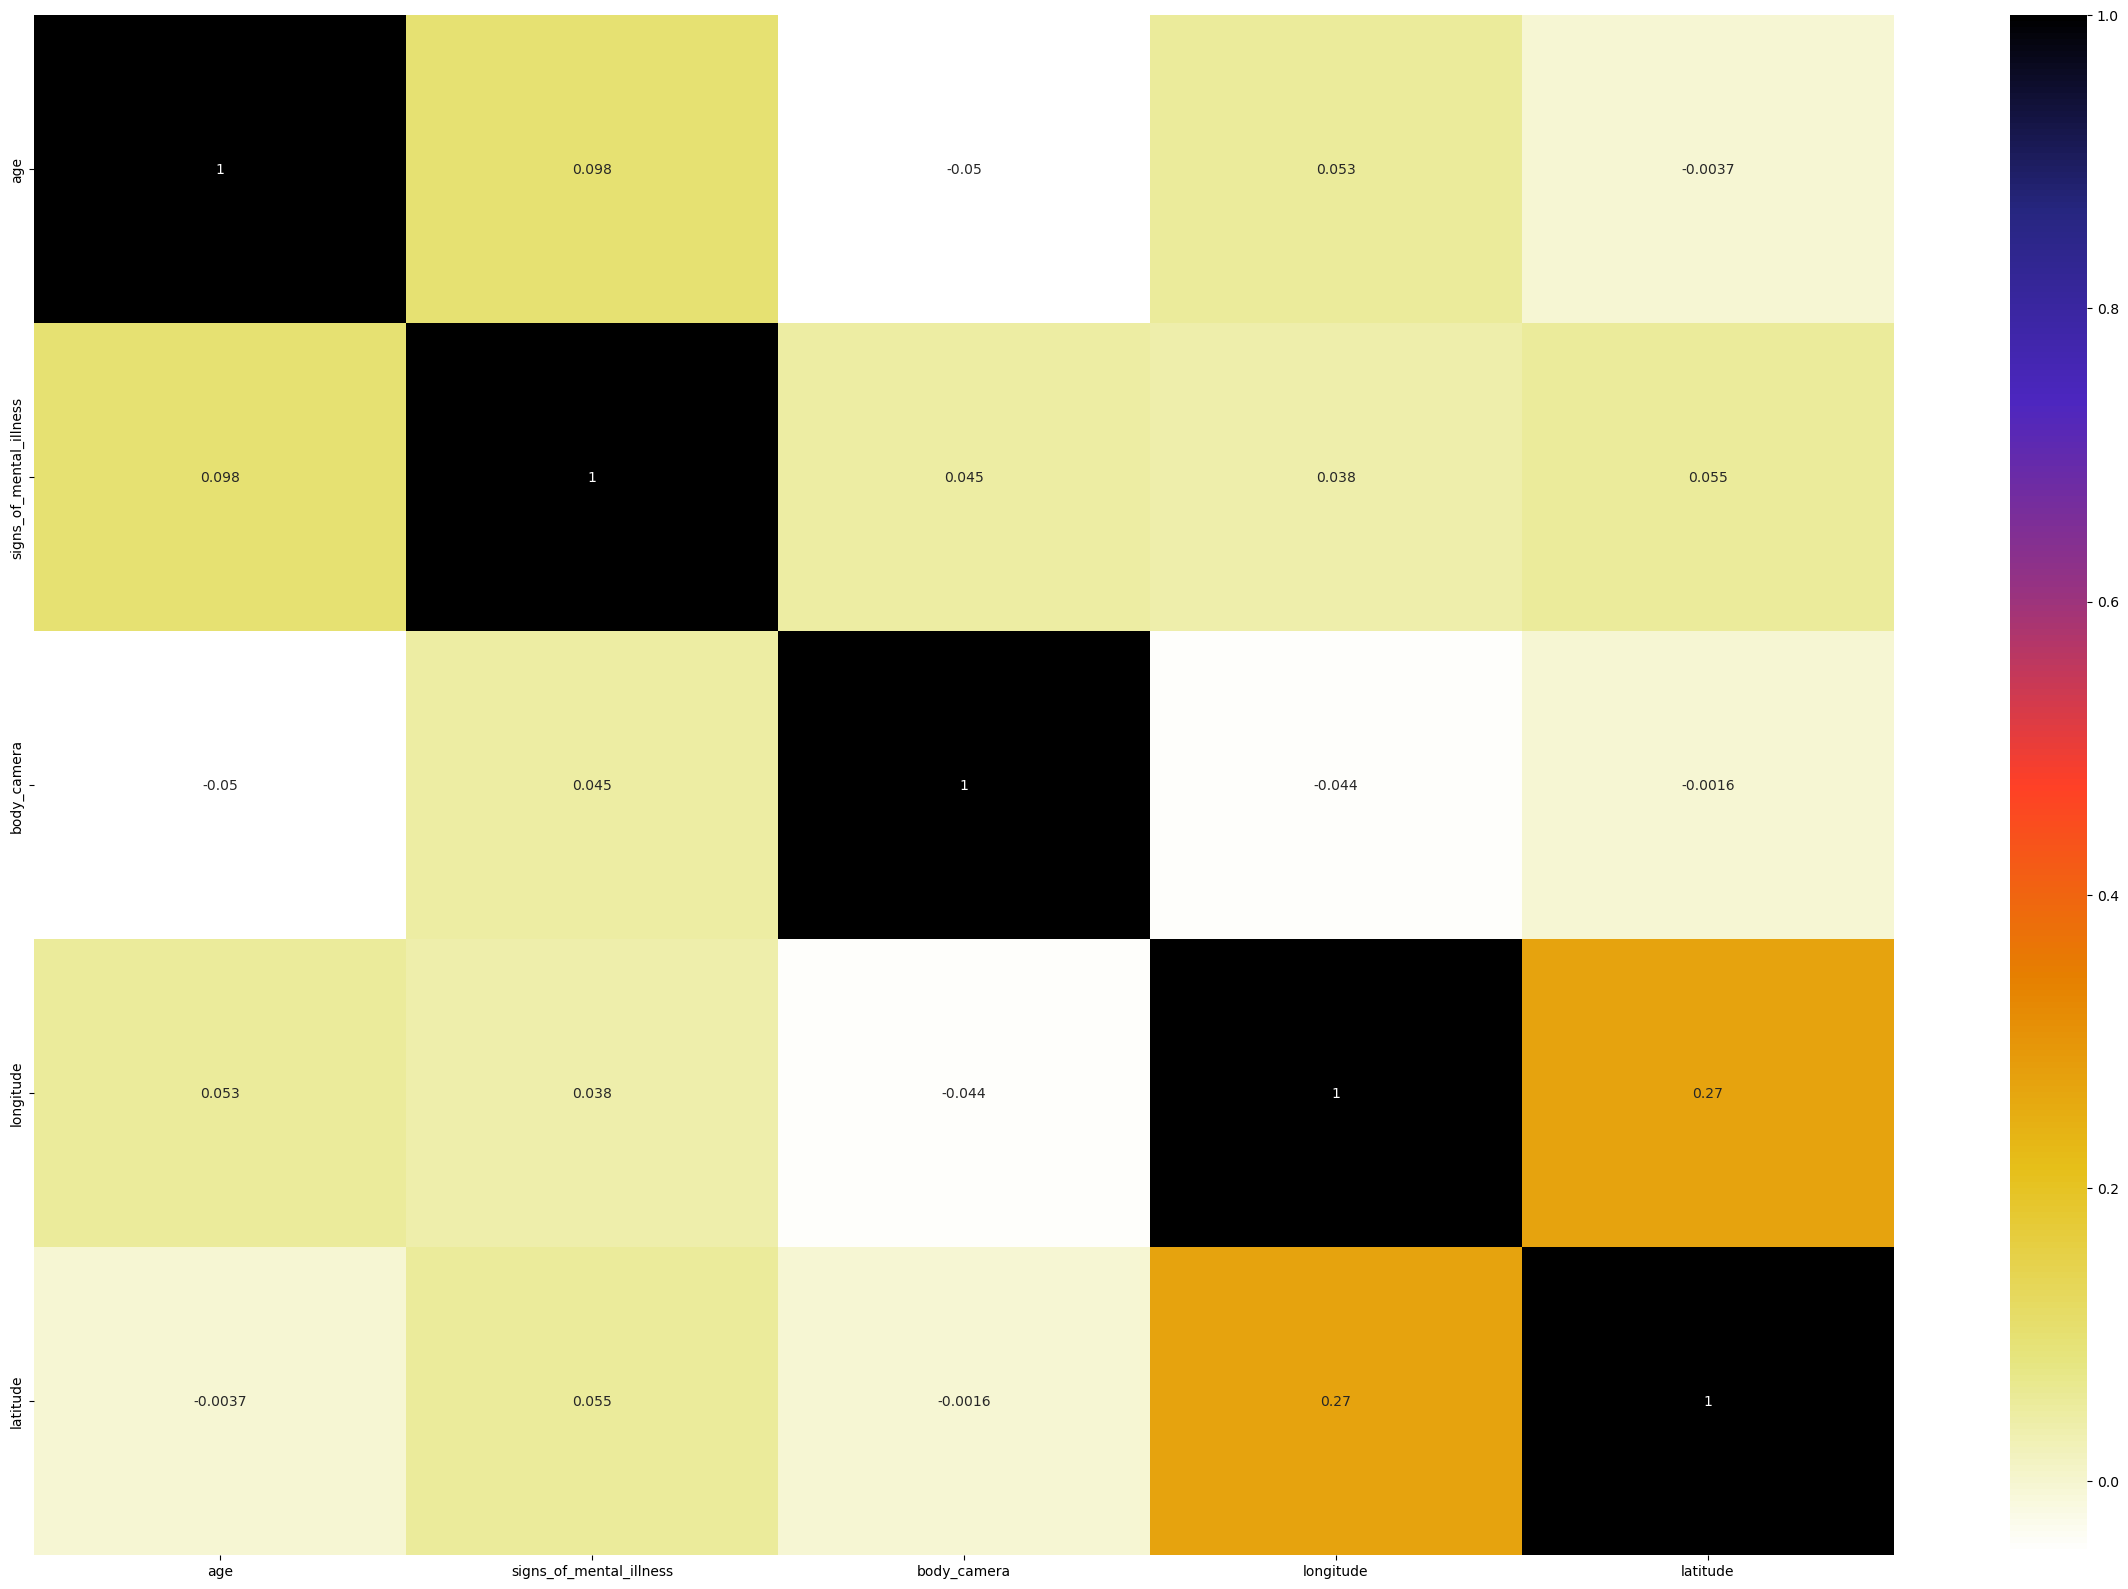

In [13]:
## Pearson correlation
plt.figure(figsize=(30,20))
cor = police_shooting_2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [14]:
police_shooting_2['armed'] = police_shooting_2['armed'].replace(to_replace=["gun and knife", "gun and vehicle", "gun and car", "guns and explosives", "machete and gun", "machete and hammer", "gun and sword", "flare gun", "hatchet and gun", "gun and machete", "vehicle and gun"], value="gun")
police_shooting_2['armed'] = police_shooting_2['armed'].replace(to_replace=["knife, hammer and gasoline can", "car, knife and mace", "car knife and mace", "ice pick", "baseball bat and knife", "ax and machete" "pole and knife", "lawn mower blade", "chain saw", "samurai sword", "pick-axe", "straight edge razor", "glass shard", "pair of scissors", "box cutter", "hatchet", "screwdriver", "sword", "ax", "machete", "pitchfork", "vehicle and machete", "knife and vehicle", "ax and machete", "meat cleaver", "chainsaw", "pole and knife"], value="sharp object")
police_shooting_2['armed'] = police_shooting_2['armed'].replace(to_replace=["hammer", "oar", "baseball bat", "metal pipe", "piece of wood", "pipe", "shovel", "metal object", "baton", "blunt object", "crowbar", "metal pole", "tire iron", "metal stick", "pole", "baseball bat and bottle", "baseball bat and fireplace poker", "carjack", "flagpole", "hammer and garden tool", "hand torch", "metal rake", "stake", "walking stick", "wrench"], value="deadly blunt objects")
police_shooting_2['armed'] = police_shooting_2['armed'].replace(to_replace=["wasp spray", "stapler", "pen", "microphone", "fireworks", "cordless drill", "barstool", "pepper spray", "flashlight", "brick", "metal hand tool", "chain", "bottle", "beer bottle", "chair", "garden tool", "shovel", "binoculars", "air conditioner", "contractor's level"], value="miscellaneous non-lethal objects")
police_shooting_2['armed'] = police_shooting_2['armed'].replace(to_replace=["BB gun", "toy weapon", "Airsoft pistol", "pellet gun", "air pistol", "BB gun and vehicle", ], value="toy gun")
police_shooting_2['armed'] = police_shooting_2['armed'].replace(to_replace=["motorcycle"], value="vehicle")
police_shooting_2['armed'] = police_shooting_2['armed'].replace(to_replace=["undetermined"], value="NG")
police_shooting_2['armed'] = police_shooting_2['armed'].replace(to_replace=["incendiary weapon"], value="incendiary device")
police_shooting_2['armed'] = police_shooting_2['armed'].replace(to_replace=["nail gun", "spear", "crossbow", "bean-bag gun", "bow and arrow", "rock", "railroad spikes"], value="miscellaneous lethal weapons")

In [15]:
police_shooting_2.to_csv('US Police shootings in from 2015-22_Clean.csv', index=False)

In [16]:
police_shooting_3 = police_shooting_2.copy()

In [17]:
states = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}

In [18]:
races = {
    'A': 'American Native',
    'W': 'White',
    'H': 'Hispanic',
    'B': 'Black',
    'O': 'Unknown',
    'N': 'Not Hispanic',
    'NG': 'NG'
}

In [19]:
police_shooting_3['state'] = police_shooting_3['state'].apply(lambda x: states[x])
police_shooting_3['race'] = police_shooting_3['race'].apply(lambda x: races[x])

In [20]:
police_shooting_3['race'].loc[police_shooting_3['race'] == 'Unknown'] = 'NG'

C:\Users\nayan\AppData\Local\Temp\ipykernel_336\1154120183.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  police_shooting_3['race'].loc[police_shooting_3['race'] == 'Unknown'] = 'NG'


In [21]:
police_shooting_3.to_csv('US Police shootings in from 2015-22_Clean.csv', index=False)

In [22]:
police_shooting_4 = police_shooting_3.copy()

In [23]:
police_shooting_4

,date,armed,age,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude
0,2015-01-02,gun,53.0,American Native,Shelton,Washington,True,attack,Not fleeing,False,-123.122,47.247
1,2015-01-02,gun,47.0,White,Aloha,Oregon,False,attack,Not fleeing,False,-122.892,45.487
2,2015-01-03,unarmed,23.0,Hispanic,Wichita,Kansas,False,other,Not fleeing,False,-97.281,37.695
3,2015-01-04,toy gun,32.0,White,San Francisco,California,True,attack,Not fleeing,False,-122.422,37.763
4,2015-01-04,miscellaneous lethal weapons,39.0,Hispanic,Evans,Colorado,False,attack,Not fleeing,False,-104.692,40.384
...,...,...,...,...,...,...,...,...,...,...,...,...
7724,2022-09-07,sharp object,35.0,NG,Flagstaff,Arizona,False,other,Foot,False,-111.584,35.224
7725,2022-09-07,gun,35.0,White,Springville,Alabama,False,attack,Car,False,-86.472,33.775
7726,2022-09-07,knife,61.0,Black,St. Louis,Missouri,False,other,Not fleeing,False,-90.290,38.668
7727,2022-09-07,gun,27.0,NG,Washington County,Tennessee,False,attack,Other,False,-82.539,36.309


In [24]:
police_shooting_5 = police_shooting_4.drop(columns=['age', 'signs_of_mental_illness', 'body_camera', 'longitude', 'latitude', 'threat_level', 'flee'])

In [25]:
police_shooting_5

,date,armed,race,city,state
0,2015-01-02,gun,American Native,Shelton,Washington
1,2015-01-02,gun,White,Aloha,Oregon
2,2015-01-03,unarmed,Hispanic,Wichita,Kansas
3,2015-01-04,toy gun,White,San Francisco,California
4,2015-01-04,miscellaneous lethal weapons,Hispanic,Evans,Colorado
...,...,...,...,...,...
7724,2022-09-07,sharp object,NG,Flagstaff,Arizona
7725,2022-09-07,gun,White,Springville,Alabama
7726,2022-09-07,knife,Black,St. Louis,Missouri
7727,2022-09-07,gun,NG,Washington County,Tennessee


In [26]:
ml_data = police_shooting_5.groupby(['date', 'race', 'state']).size().reset_index()

In [27]:
ml_data = ml_data.rename({0: 'Y'}, axis=1)

In [28]:
ml_data.to_csv('ml_data.csv', index=False)

In [29]:
# ml_data_1 = ml_data.set_index('dateGroupped')
ml_data_1 = ml_data.copy()

In [30]:
ml_data_1.insert(0, "shooting_year", ml_data_1['date'].dt.year)
ml_data_1.insert(1, "shooting_month", ml_data_1['date'].dt.month)
ml_data_1.insert(2, "shooting_week", ml_data_1['date'].dt.isocalendar().week)

In [31]:
ml_data_1.drop(columns=['date'], inplace=True)

In [32]:
ml_data_1

,shooting_year,shooting_month,shooting_week,race,state,Y
0,2015,1,1,American Native,Washington,1
1,2015,1,1,White,Oregon,1
2,2015,1,1,Hispanic,Kansas,1
3,2015,1,1,Hispanic,Colorado,1
4,2015,1,1,White,California,1
...,...,...,...,...,...,...
7502,2022,9,36,Black,Missouri,1
7503,2022,9,36,NG,Arizona,1
7504,2022,9,36,NG,Georgia,1
7505,2022,9,36,NG,Tennessee,1


In [33]:
unique_race_count = len(ml_data_1['race'].unique())
unique_state_count = len(ml_data_1['state'].unique())

In [34]:
ml_data_2 = pd.get_dummies(ml_data_1, columns=['race', 'state'], prefix='', prefix_sep='').iloc[:, :-1]

In [35]:
encoding_race_columns = list(ml_data_2.columns)[list(ml_data_2.columns).index('Y')+1:list(ml_data_2.columns).index('Y')+1+unique_race_count]
encoding_state_columns = list(ml_data_2.columns)[list(ml_data_2.columns).index('Y')+1+unique_race_count: list(ml_data_2.columns).index('Y')+1+unique_race_count+unique_state_count]

In [36]:
def get_dummies(df:pd.DataFrame, column_name):
    if column_name == 'race':
        dummy = pd.DataFrame([], columns=encoding_race_columns, index=df.index)
        for index, row in df.iterrows():
            dummy.loc[index] = [int(row[column_name] == name) for name in encoding_race_columns]
        return dummy
    else:
        dummy = pd.DataFrame([], columns=encoding_state_columns, index=df.index)
        for index, row in df.iterrows():
            dummy.loc[index] = [int(row[column_name] == name) for name in encoding_state_columns]
        return dummy

In [37]:
def one_hot_encoding(data_frame: pd.DataFrame, categorical_columns):
  data_frame = data_frame.copy()

  for column in categorical_columns:
    slice_data_frame = data_frame[[column]]
    dummy = get_dummies(slice_data_frame, column)
    data_frame.drop([column], axis=1, inplace=True)
    data_frame = pd.concat([data_frame, dummy], axis=1)
  return data_frame

In [38]:
# scale train and test data to [0, 1]
def scaler(df):
	# x scaler
	scaler = MinMaxScaler(feature_range=(0, 1)).fit(df)

	data_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
	return scaler, data_scaled

In [39]:
ml_data_3 = ml_data_2.loc[:, ml_data_2.columns != 'Y']

In [40]:
data_scaler, ml_data_4 = scaler(ml_data_3)

In [41]:
X = ml_data_4
Y = ml_data_2['Y']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0)

In [44]:
data_gen_train = TimeseriesGenerator(X_train.to_numpy(), y_train.to_numpy(), length=4, batch_size=1)
data_gen_test = TimeseriesGenerator(X_test.to_numpy(), y_test.to_numpy(), length=4, batch_size=1)

In [45]:
simodel = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(4, 59)),
    Dropout(0.2),
    LSTM(100, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
simodel.compile(loss='mean_squared_error', optimizer='adam')
simodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 100)            64000     
                                                                 
 dropout (Dropout)           (None, 4, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 144,501
Trainable params: 144,501
Non-trainable params: 0
_________________________________________________________________


In [46]:
si_mode_history = simodel.fit(data_gen_train, epochs=15, batch_size=32, validation_data=data_gen_test, callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

Epoch 1/15
5250/5250 [==============================] - 19s 3ms/step - loss: 0.0444 - val_loss: 0.0305
Epoch 2/15
5250/5250 [==============================] - 16s 3ms/step - loss: 0.0358 - val_loss: 0.0290
Epoch 3/15
5250/5250 [==============================] - 18s 3ms/step - loss: 0.0342 - val_loss: 0.0284
Epoch 4/15
5250/5250 [==============================] - 16s 3ms/step - loss: 0.0332 - val_loss: 0.0283
Epoch 5/15
5250/5250 [==============================] - 19s 4ms/step - loss: 0.0322 - val_loss: 0.0293
Epoch 6/15
5250/5250 [==============================] - 18s 3ms/step - loss: 0.0312 - val_loss: 0.0303
Epoch 7/15
5250/5250 [==============================] - 16s 3ms/step - loss: 0.0313 - val_loss: 0.0307
Epoch 8/15
5250/5250 [==============================] - 16s 3ms/step - loss: 0.0280 - val_loss: 0.0322
Epoch 9/15
5250/5250 [==============================] - 16s 3ms/step - loss: 0.0260 - val_loss: 0.0357
Epoch 10/15
5250/5250 [==============================] - 18s 4ms/step - l

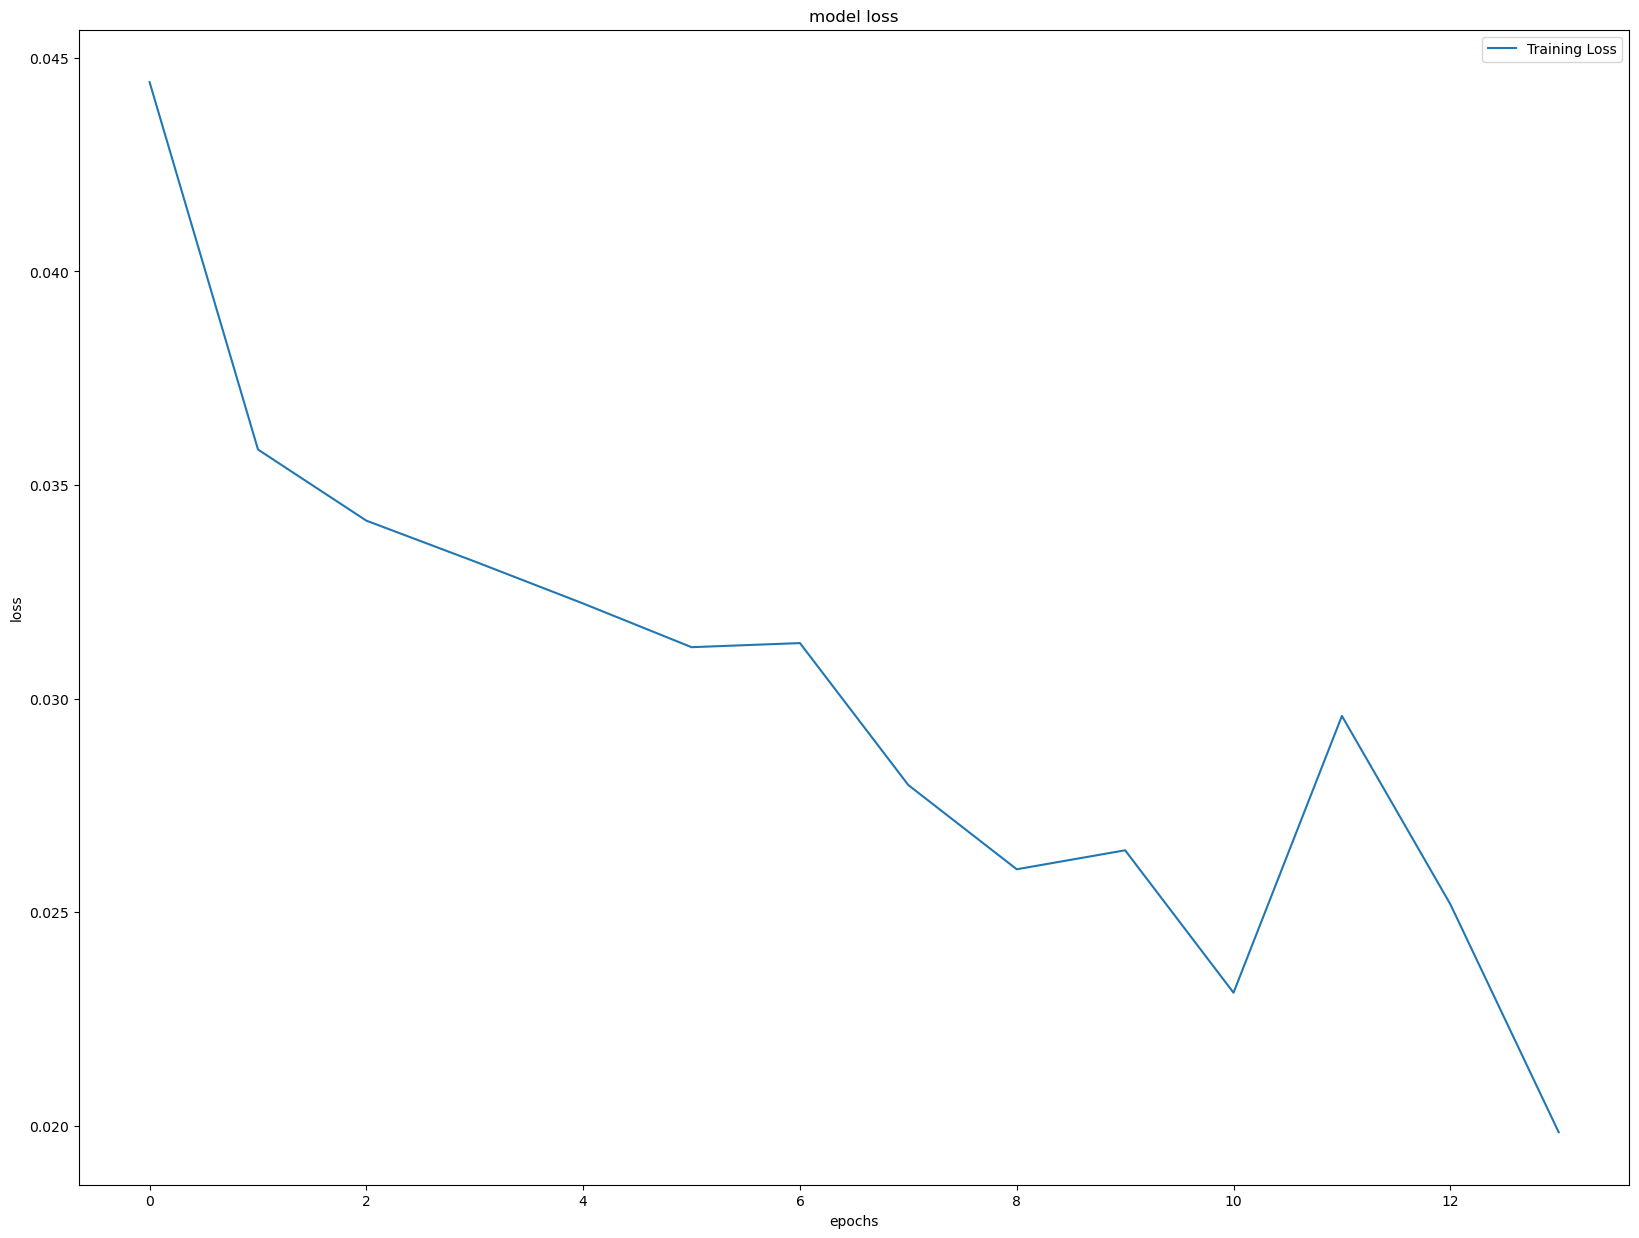

In [47]:
plt.figure(figsize=(20,15))
plt.plot(si_mode_history.history['loss'], label='Training Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [48]:
result = simodel.predict(data_gen_test)

2249/2249 [==============================] - 3s 1ms/step


In [49]:
test = []
for i in range(len(data_gen_test)):
	x, y = data_gen_test[i]
	test.append(y[0])

In [50]:
print('Test Mean Absolute Error:', mean_squared_error(test, np.ceil(result)))

Test Mean Absolute Error: 0.8248110271231659


## Predict

In [51]:
def predict(state: str, race: str, base_date: datetime, days: int):
    df = pd.DataFrame([], columns=['date', 'race', 'state'])
 
    for _ in range(1, days + 1):
        df.loc[len(df.index)] = [base_date, race, state]
        base_date = base_date + datetime.timedelta(days=1)
    
    return df.reset_index(drop=True)

In [52]:
result = pd.DataFrame([],  columns=['date', 'state', 'race', 'prediction'])

for state in police_shooting_5['state'].unique():
    for race in police_shooting_5['race'].unique():
        init_date = datetime.datetime(2022, 1, 1)
        pre = predict(state, race, init_date, 365)
        pre.insert(0, "shooting_year", pre['date'].dt.year)
        pre.insert(1, "shooting_month", pre['date'].dt.month)
        pre.insert(2, "shooting_week", pre['date'].dt.isocalendar().week)
        pre.drop(columns=['date'], inplace=True)
        
        pre_1 = one_hot_encoding(pre, ['race', 'state'])
        pre_1_scaled = data_scaler.transform(pre_1)
        
        data_gen_pre = TimeseriesGenerator(pre_1_scaled, np.repeat(1, len(pre_1_scaled)), length=4, batch_size=1)
        result_pre = simodel.predict(data_gen_pre)
     
        for rp in result_pre:
            result.loc[len(result.index)] = [init_date, state, race, rp[0]]
            init_date = init_date + datetime.timedelta(days=1)

361/361 [==============================] - 1s 2ms/step


In [53]:
result.to_csv('Prediction.csv', index=False)